In [22]:
import os
import tensorflow as tf
import keras 
import keras.layers as layers
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
# warnings.filterwarnings('ignore')
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
tf.debugging.set_log_device_placement(True)


In [25]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [26]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

train_dir = os.path.join(parent_dir, current_dir, 'data', 'processed', 'train')
test_dir = os.path.join(parent_dir, current_dir, 'data', 'processed', 'test')
img_size = (64, 128, 1)


In [27]:
train_ds = keras.utils.image_dataset_from_directory(
  train_dir, 
  labels='inferred',
  color_mode='grayscale',
  image_size=(img_size[0], img_size[1]),
)
valid_ds = keras.utils.image_dataset_from_directory(
  test_dir, 
  labels='inferred',
  color_mode='grayscale',
  image_size=(img_size[0], img_size[1]),
)
num_classes = len(train_ds.class_names)
target_names = valid_ds.class_names

# for image_batch, labels_batch in valid_ds:
#   for i in range(len(image_batch)):
#     plt.imshow(image_batch[i].numpy().astype("uint8")[:, :, 0], cmap='gray')
#     plt.title(f"Label: {labels_batch[i].numpy()}")
#     plt.show()

# for image_batch, labels_batch in train_ds:
#   for i in range(len(image_batch)):
#       plt.imshow(image_batch[i].numpy().astype("uint8")[:, :, 0], cmap='gray')
#       plt.title(f"Label: {labels_batch[i].numpy()}")
#       plt.show()


Found 552 files belonging to 184 classes.
Found 184 files belonging to 184 classes.


In [28]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [29]:
data_augmentation = keras.Sequential(
  [
    # layers.RandomFlip("horizontal", input_shape=img_size),
    layers.RandomRotation(0.1, input_shape=img_size),
    layers.RandomZoom(0.1),
    layers.Lambda(lambda x: 1 - x) 

  ]
)

model = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(num_classes,activation='softmax', name="outputs")
])


In [30]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 64, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 64, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 128, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 16, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 16, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 184)            │        23,736 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,744 (1.32 MB)

 Trainable params: 346,488 (1.32 MB)

 Non-trainable params: 256 (1.00 KB)

In [32]:
early_stopping = keras.callbacks.EarlyStopping(
  patience=10,
  min_delta=0.001,
  restore_best_weights=True,
)

epochs = 50
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/50


2024-09-28 01:19:57.713379: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0083 - loss: 5.3700 - val_accuracy: 0.0054 - val_loss: 5.2196
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0028 - loss: 5.2394 - val_accuracy: 0.0109 - val_loss: 5.1868
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0124 - loss: 5.0448 - val_accuracy: 0.0163 - val_loss: 5.1240
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0355 - loss: 4.7868 - val_accuracy: 0.0326 - val_loss: 5.0267
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0768 - loss: 4.6190 - val_accuracy: 0.0326 - val_loss: 4.9129
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1120 - loss: 4.4088 - val_accuracy: 0.0272 - val_loss: 4.7906
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1572 - loss: 4.2060 - val_accuracy: 0.0380 - val_loss: 4.6555
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1786 - loss: 4.0793 - val_accuracy: 0.0489 - val_loss: 4.

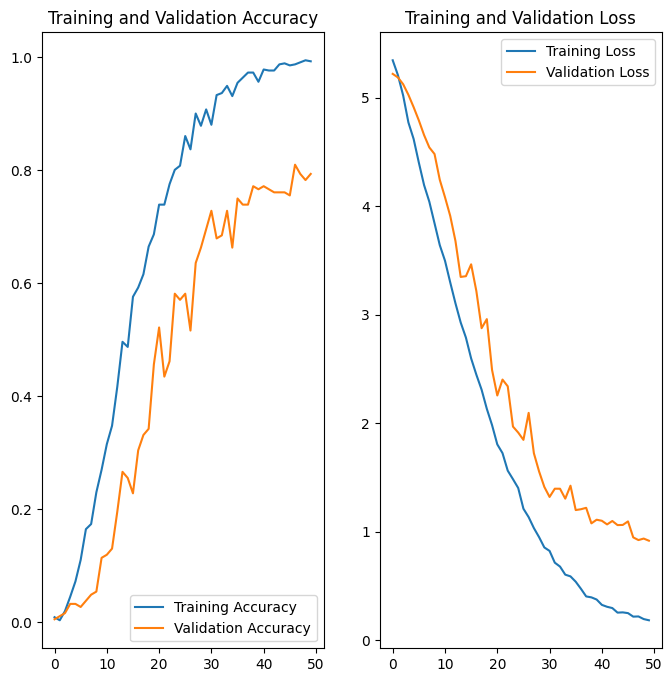

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # Ensure epochs_range matches the length of acc and val_acc

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
import numpy as np

# Get predictions on the validation set
y_pred_prob = model.predict(valid_ds)  # Predict class probabilities
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()  # Convert probabilities to class labels

y_true = []
for images, labels in valid_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)  # Convert the list to a numpy array


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [35]:
from sklearn.metrics import classification_report, accuracy_score

# Classification report for precision, recall, and F1-score
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)

# Accuracy score
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
         100       1.00      1.00      1.00         1
         101       0.00      0.00      0.00         1
         102       0.00      0.00      0.00         1
         103       1.00      1.00      1.00         1
         104       0.50      1.00      0.67         1
         105       0.00      0.00      0.00         1
         106       1.00      1.00      1.00         1
         107       0.00      0.00      0.00         1
         108       1.00      1.00      1.00         1
         109       0.00      0.00      0.00         1
          11       1.00      1.00      1.00         1
         110       1.00      1.00      1.00         1
         111       1.00      1.00      1.00         1
         112       0.00      0.00      0.00         1
         113       0.25      1.00      0.40         1
         114       0.00    

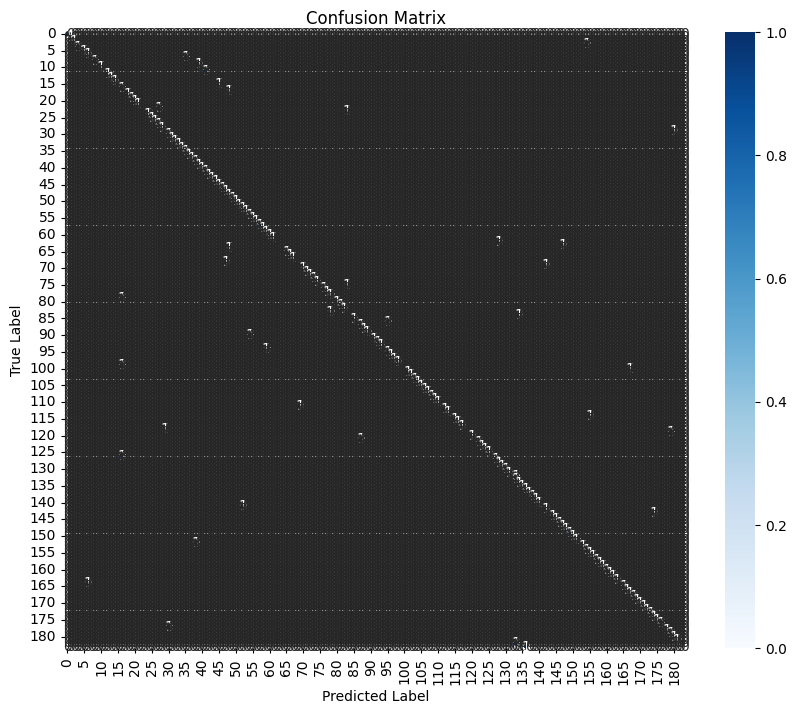

In [36]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Visualize the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [37]:
base_model = tf.keras.applications.ResNet50(input_shape=(img_size[0], img_size[1], 3),include_top=False,weights='imagenet')

base_model.trainable = False  # Freeze the base model layers
model = keras.Sequential([
    layers.InputLayer(input_shape=(img_size[0], img_size[1], 1)),  # Original input shape
    layers.Conv2D(3, (3, 3), padding='same', activation='relu'),  # Convert grayscale to RGB
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Replace num_classes with the actual number of classes
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 64, 128, 3)     │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 184)            │        23,736 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,873,750 (91.07 MB)

 Trainable params: 286,038 (1.09 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [38]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 309ms/step - accuracy: 0.0072 - loss: 5.4751 - val_accuracy: 0.0326 - val_loss: 5.0909
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0403 - loss: 5.0037 - val_accuracy: 0.0815 - val_loss: 4.7662
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.1626 - loss: 4.4248 - val_accuracy: 0.1630 - val_loss: 4.2647
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3034 - loss: 3.5195 - val_accuracy: 0.3043 - val_loss: 3.6515
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4162 - loss: 2.8477 - val_accuracy: 0.3315 - val_loss: 2.9985
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6248 - loss: 2.0775 - val_accuracy: 0.4511 - val_loss: 2.5647
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7629 - loss: 1.4671 - val_accuracy: 0.4620 - val_loss: 2.2630
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7983 - loss: 1.0821 - val_accuracy: 0.5326 -

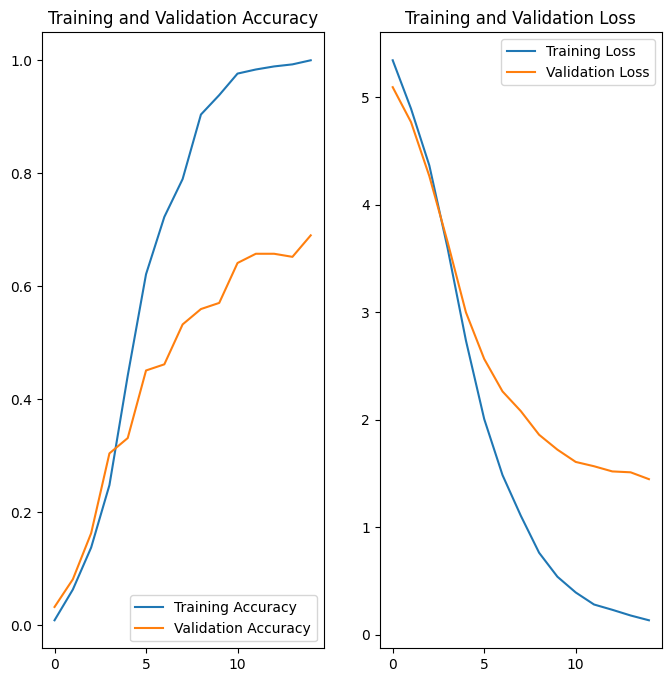

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
import numpy as np

# Get predictions on the validation set
y_pred_prob = model.predict(valid_ds)  # Predict class probabilities
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()  # Convert probabilities to class labels

y_true = []
for images, labels in valid_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)  # Convert the list to a numpy array


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 361ms/step


2024-09-28 01:20:58.111443: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


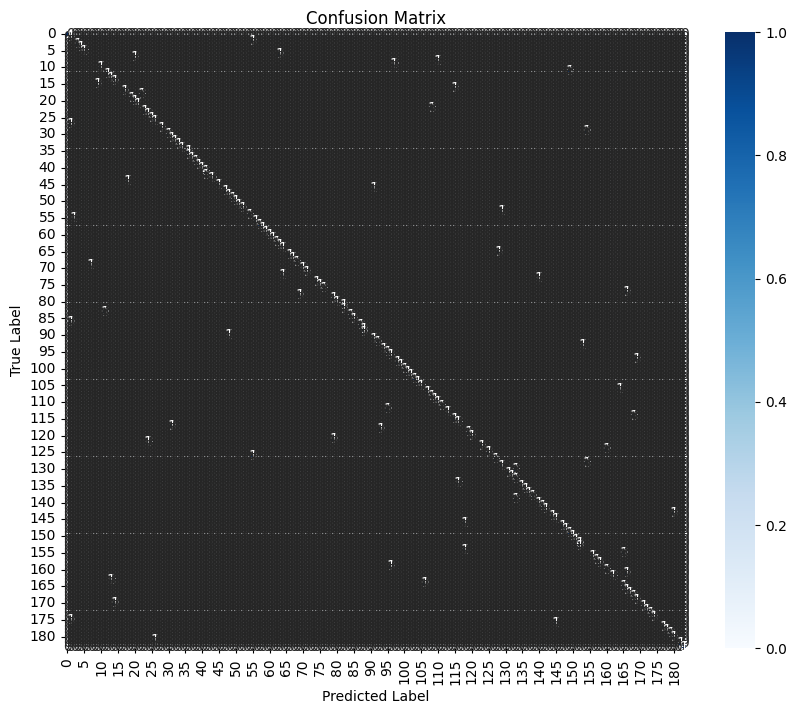

In [41]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Visualize the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()